# Problem Statement

The task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

#### Evaluation Metric
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


#### Key points

- The E-commerce company sells multiple products on its platform
- User behavior is recorded in the logs
- View log of users is for around 22 days (15th Oct 2018 - 5th Nov 2018)
- Train data has the impression logs for 29 days (15th Nov 2018 – 13th Dec 2018) along with the label which specifies whether the ad is clicked or not
- Test data have impression logs for 7 days (12th Dec 2018 – 18th Dec 2018) without the labels
- 12th and 13th Dec are overlap between train and test dataset. We can put a lookup to see if the user_id matches then, for those we can input the values
- The product description is collected from the Zbay website

# Good reference links

- Sample solution of similar problem
https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff

# 1. Load Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Dataset

In [2]:
train=pd.read_csv("train.csv")
view_log=pd.read_csv("view_log.csv")
item_data=pd.read_csv("item_data.csv")
test=pd.read_csv("test.csv")

- view_log contains data on user behaviour

# 3. Data Exploration

In [3]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


- app_code is the publisher id

In [20]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [22]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


- category_1	Category depth 1
- category_2	Category depth 2
- category_3	Category depth 3
- product_type	anonymized item type
- -->> What is the difference between item type and category

In [19]:
print("shape of train data",train.shape)
print("===============================")
print("shape of log data",view_log.shape)
print("===============================")
print("shape of item data",item_data.shape)
print("===============================")
print("shape of train data",test.shape)

shape of train data (237609, 7)
shape of log data (3118622, 5)
shape of item data (132761, 6)
shape of train data (90675, 6)


# Variable Types

- impression_id : Id can be ignored (which ad is driving more clicks) -237609 unique ads
- user_id : Id can be ignored (Is a repetitive users who isn't clicking for a particular item? or, is there any user who is always clicking but not buying an item?) - 74723 unique users
- session_id : Id can be ignored
- item_id : Id can be ignored (which item is getting more clicks?) - 126708 unique products
- app_code : Categorical (490 categories) - publisher id (which publisher is driving more traffic?)
******************************************************************************************************************
- impression_time : DateTime - Can be used for Day of week, Time of day analysis
- os_version : Categorical (3 categories)
- is_4G : Categorical (2 categories)
- server_time : Timestamp of the log
- device_type : Categorical (3 categories)
- item_price : Continuous (Numerical)
- category_1 : Categorical (17 categories)
- category_2 : Categorical (79 categories)
- category_3 : Categorical (335 categories)
- product_type : Categorical (7959 categories)
- is_click : Categorical (Target Variable)

##### Can be ignored
- impression_id : Id can be ignored 
- user_id : Id can be ignored
- session_id : Id can be ignored
- item_id : Id can be ignored
- app_code : Categorical (490 categories) - publisher id - It would have be better if publisher category was given rather than publisher id

In [28]:
print("Number of categories in app_code")
print(train["app_code"].nunique())
print("==================================================================")
print("Number of categories in os_version")
print(train["os_version"].nunique())
print("==================================================================")
print("Number of categories in is_4G")
print(train["is_4G"].nunique())
print("==================================================================")
print("Number of categories in device_type")
print(view_log["device_type"].nunique())
print("==================================================================")
print("Number of categories in category_1")
print(item_data["category_1"].nunique())
print("==================================================================")
print("Number of categories in category_2")
print(item_data["category_2"].nunique())
print("==================================================================")
print("Number of categories in category_3")
print(item_data["category_3"].nunique())
print("==================================================================")
print("Number of categories in product_type")
print(item_data["product_type"].nunique())
print("==================================================================")
print("Number of categories in impression_id")
print(train["impression_id"].nunique())
print("==================================================================")
print("Number of categories in user_id")
print(train["user_id"].nunique())
print("==================================================================")
print("Number of categories in item_id")
print(view_log["item_id"].nunique())

Number of categories in app_code
490
Number of categories in os_version
3
Number of categories in is_4G
2
Number of categories in device_type
3
Number of categories in category_1
17
Number of categories in category_2
79
Number of categories in category_3
335
Number of categories in product_type
7959
Number of categories in impression_id
237609
Number of categories in user_id
74723
Number of categories in item_id
126708


In [29]:
print("Categories in os_version")
print(train["os_version"].unique())
print("==================================================================")
print("Categories in is_4G")
print(train["is_4G"].unique())
print("==================================================================")
print("Categories in device_type")
print(view_log["device_type"].unique())

Categories in os_version
['old' 'latest' 'intermediate']
Categories in is_4G
[0 1]
Categories in device_type
['android' 'iphone' 'web']


# Questions to be explored

#### 1. Related to Data's timeframe given
- Can we merge Train and View_logs given the time frame for both is different?

      - Yes, item data can be merged as it is time independent.
      - Assuming the user doesn't change the device, we can add view_logs. Anyways from view_logs - apart from device time rest all seems not useful

#### 2. Related to variables
- How is os_version impacting the propensity to click? #imp
- How is having a 4G connection driving the clicks? #imp
- Which device type is leading to more clicks? #imp
- How is item price related to clicks? # not a realistic question
- How are the categories_1,2,3 are playing a role in clicks? Which of them is driving more?
- Which product_type is driving more clicks?
- Which time of day or day of week drives more number of clicks?
- What to do with server time?
**************************************************************************************************************************
- Do outlier analysis on Price #imp
- Do propensity to click analysis - check titanic
- Univariate, Bivariate

#### 3. Feature Engineering
- Can a variable be created based on praticle knowledge? - CTR,CPC,CPA etc. or any other adnetwork metric  

    - https://instapage.com/blog/key-advertising-metrics
    - http://blog.chapagain.com.np/google-adsense-describing-ctr-cpc-cpm-rpm-page-views-impression/
    - https://pubhelp.rakutenmarketing.com/hc/en-us/articles/200822986-What-are-CPM-CTR-CPA-and-CPC-

- Combine os_version and device_type ->>> is this a good variable, think??
- Combine is_4G and device_type ->>> is this a good variable, think??
- Combine Category_1,2,3 ->>> is this a good variable, think??
- Can we do anything from app_code - Which ad is shown where is important to increase the propensity to click (underlying belief)
#### 4. Feature Selection
- Do hypothesis testing

#### 5. Make a better model
- Stratified Cross-validation
- SMOTE #imp
- One hot Encoding
#### 6. Models to apply
- Logistic Regression
- Decision Tree
- KNN
- SVM
- Random forest
- GBM
- XGBM
- LGBM
- Catboost

## 3.1 Finding Missing Values

In [8]:
print("Missing Values in Train Dataset")
print(train.isna().sum())
print("==================================================================")
print("Missing Values in Log Dataset")
print(view_log.isna().sum())
print("==================================================================")
print("Missing Values in Item Dataset")
print(item_data.isna().sum())
print("==================================================================")
print("Missing Values in Test Dataset")
print(test.isna().sum())

Missing Values in Train Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64
Missing Values in Log Dataset
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64
Missing Values in Item Dataset
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64
Missing Values in Test Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
dtype: int64


- No missing values in the entire dataset

## 3.2 Explore Target Variable

In [9]:
# Extract target variable from train set
label = train['is_click']

In [10]:
# Check for unique values
label.unique()

array([0, 1], dtype=int64)

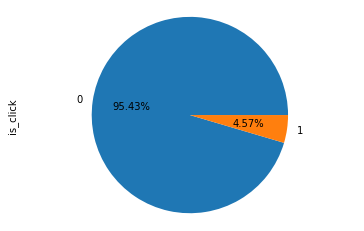

In [14]:
# Pie Plot to Visualise the Target Variable
label.value_counts().plot.pie(autopct='%1.2f%%')
plt.axis('equal')
plt.show()

- In the train dataset only 4.57% of the impressions were clicked